# Intro to this package
---

Here we introduce the functionalities of our package and the dynamical models it uses.

# 1. Setup
---
Uncomment the following line to install `rl4greencrab`. 
After installation you need to restart the jupyter kernel in order to use the package and run this notebook.

In [22]:
%pip install -e ..

Obtaining file:///home/rstudio/rl4greencrab
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for rl4greencrab (pyproject.toml) ... done
  Created wheel for rl4greencrab: filename=rl4greencrab-1.0.0-py2.py3-none-any.whl size=1069 sha256=04a2111d259dd039b329b1369e2857430f1ad1045264348157a0b65eab056871
  Stored in directory: /tmp/pip-ephem-wheel-cache-86dvoand/wheels/e9/7e/e6/00c4b11a2574abd59d64425d537139e25fadbde37f002c4dba
Successfully built rl4greencrab
  Attempting uninstall: rl4greencrab
    Found existing installation: rl4greencrab 1.0.0
    Uninstalling rl4greencrab-1.0.0:
      Successfully uninstalled rl4greencrab-1.0.0
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd
from plotnine import ggplot, aes, geom_density, geom_line, geom_point, geom_violin, facet_grid, labs

# 2. Integral projection model
---

Here we conceptually describe our integral projection model (IPM) of the crab population dynamics.

Our model describes the process in which an agent observes green crab counts by laying traps to catch the crabs. 
Each time-step corresponds to a year's worth of data, and has two components: 
First, for 9 months crabs are caught using traps laid by the agent.
Second, for the last 3 months of the year, the crabs undergo a gestation period and no crabs are caught during this time.
This is the timeline of a time-step:
1. The agent receives an observation (nine months' worth of catch data).
2. The agent decides a density of traps to lay for the next year.
3. The population dynamics model evolves somatically for nine months, each month producing an overall catch count observation. This observation is sampled from a distribution that depends on the size-structure of the crab population.
5. New crabs are spawned and grow for 3 months. The number of new-borns is determined by a logistic function (plus a random term). During this timeline, too, new crabs immigrate with a fixed immigration rate.

The following code block shows the input and output of this model.
Our model is encoded as a `gymnasium env` class in order to leverage existing RL algorithms.

In [2]:
from rl4greencrab import greenCrabEnv

gce = greenCrabEnv()

After declaring `gce`, the `.reset()` function sets the state of the crab population to its initial value, and produces the following output:

`initial observation`, `info`.

Currently, `initial observation` is a random sequence of numbers for simplicity's sake.

In [3]:
observation, info = gce.reset()
observation

array([97., 49., 70., 64., 29., 68., 37., 95., 49.], dtype=float32)

A dynamical step for the IPM is produced by  the `.step(action)` function.
Here, the `action` argument takes values in [0, 2000] and corresponds to the number of traps laid.
The output is

`observation`, `reward`, `terminated`, `truncated`, `info`

The latter three outputs are beyond the scope of this notebook.
The `reward` output is used by the agent to train---the agent looks for strategies that lead to high average rewards over 100 time-steps.

The following call of the step function returns a null observation since no traps were laid.

In [4]:
observation, reward, terminated, truncated, info = gce.step([0])
observation

array([0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

Lets try some other action values and see what observations we obtain:

In [5]:
# 1.
_ = gce.reset()
observation, reward, terminated, truncated, info = gce.step([1])
observation

array([2., 1., 1., 1., 1., 0., 1., 2., 2.], dtype=float32)

In [6]:
# 2.
_ = gce.reset()
observation, reward, terminated, truncated, info = gce.step([10])
observation

array([10., 13., 10.,  3., 10.,  6.,  7.,  8., 11.], dtype=float32)

In [7]:
# 3.
_ = gce.reset()
observation, reward, terminated, truncated, info = gce.step([100])
observation

array([76., 66., 70., 56., 74., 56., 57., 64., 41.], dtype=float32)

## Plotting population distribution over time without traps

The state of our model is a size-resolved population distribution, with 21 size classes.

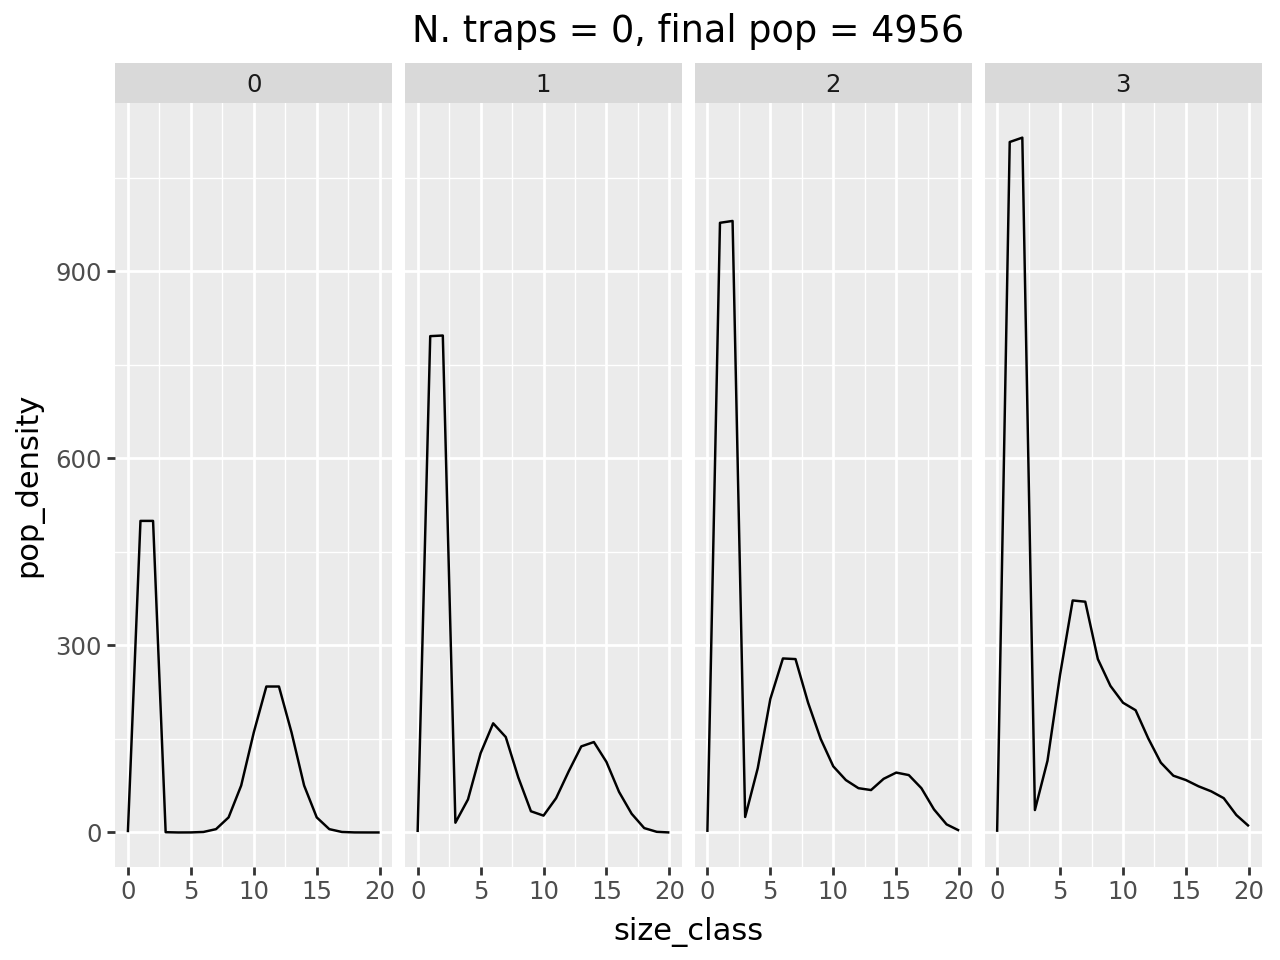

In [8]:
gce.reset()
size_dist = pd.DataFrame(
    {
        'pop_density': gce.state,
        'size_class': list(range(21)),
        't': 21*[0],
    }
)

for t in range(1,4):
    gce.step([0])
    new_size_dist = pd.DataFrame(
        {
            'pop_density': gce.state,
            'size_class': list(range(21)),
            't': 21*[t],
        }
    )
    size_dist = pd.concat(
        [size_dist, new_size_dist],
        ignore_index=True,
    )
    new_total_pop = pd.DataFrame({'pop': [sum(gce.state)], 't': [t]})

ggplot(size_dist, aes(x='size_class',y='pop_density')) + geom_line() + facet_grid(cols='t') + labs(title=f"N. traps = 0, final pop = {sum(gce.state):.0f}")




## Plotting population *with* traps

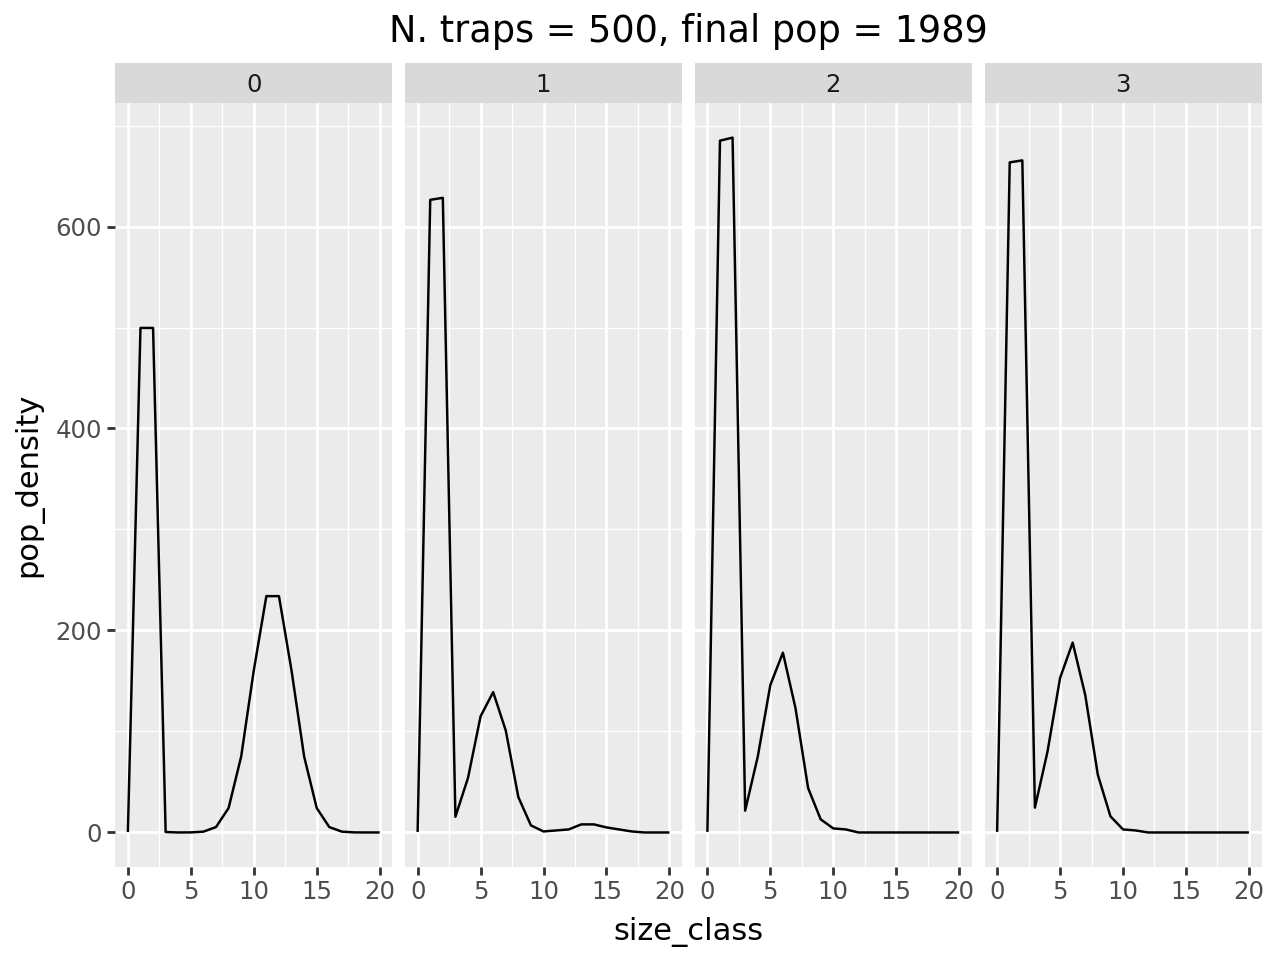

In [9]:
n_traps = 500

gce.reset()
size_dist = pd.DataFrame(
    {
        'pop_density': gce.state,
        'size_class': list(range(21)),
        't': 21*[0],
    }
)

for t in range(1,4):
    gce.step([n_traps])
    new_size_dist = pd.DataFrame(
        {
            'pop_density': gce.state,
            'size_class': list(range(21)),
            't': 21*[t],
        }
    )
    size_dist = pd.concat(
        [size_dist, new_size_dist],
        ignore_index=True,
    )
    new_total_pop = pd.DataFrame({'pop': [sum(gce.state)], 't': [t]})

ggplot(size_dist, aes(x='size_class',y='pop_density')) + geom_line() + facet_grid(cols='t') + labs(title=f"N. traps = {n_traps}, final pop = {sum(gce.state):.0f}")

## The reward function

At each time-step, our model returns a `reward` which depends on two things: the crab population distribution (this term of the reward quantifies the ecological damage due to the crab population), and the cost of laying traps. It has the following functional form:

$ R = - D(P) - \alpha A$

where $D(P)$ is the ecological damage arising from a population $P$ of crabs, $A$ is the action taken by the agent and $\alpha$ is a constant of the model (in the source code $\alpha$ is the attribute `gce.action_reward_scale`)

In [10]:
from rl4greencrab import simulator, constAction
import pandas as pd
import matplotlib.pyplot as plt

stats = []
for n_traps in [0, 10, 50, 100, 200]:
    rewards = simulator(greenCrabEnv(), constAction(n_traps)).simulate()
    stats.append([n_traps, np.mean(rewards), np.std(rewards)])

stats_df = pd.DataFrame(stats, columns=['n_traps', 'rew_mean', 'rew_std'])
stats_df
# stats_df.plot(x='n_traps', y='rew_mean', yerr='rew_std');
# plt.show()

,n_traps,rew_mean,rew_std
0,0,-10.760099,0.083178
1,10,-0.014162,0.000023
2,50,-0.017543,0.000022
3,100,-0.022435,0.000023
4,200,-0.032384,0.000018
